# SVG-VAE

In [1]:
import pyarrow.parquet as pq
import svg_utils
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch.utils.data import Dataset, DataLoader
from model import VAEModel
from config import ImageVAEConfig

## Prepare dataset

In [2]:
data_train = pq.read_table('data_train.parquet')
data_train = data_train.to_pandas()

data_test = pq.read_table('data_test.parquet')
data_test = data_test.to_pandas()

data_train.head()

,uni,width,vwidth,sfd,id,binary_fp
0,97,649,1000,"SplineSet\n637 0 m 1,0,-1\n 595 0 l 1,1,-1\n 5...",1,12127215344058962203\n
1,98,560,1000,"SplineSet\n535 284 m 0,0,1\n 535 166 535 166 4...",2,12127215344058962203\n
2,99,712,1000,"SplineSet\n693 125 m 1,0,1\n 686 116 686 116 6...",3,12127215344058962203\n
3,100,710,1000,"SplineSet\n678 378 m 0,0,1\n 678 221 678 221 5...",4,12127215344058962203\n
4,101,613,1000,"SplineSet\n586 0 m 1,0,-1\n 28 0 l 1,1,-1\n 28...",5,12127215344058962203\n


In [3]:
len(data_train)

1971326

Взглянем на сэмпл.

In [4]:
from random import randint
i = 1358568 # randint(0, 1971326)

In [5]:
assert svg_utils._is_valid_glyph(data_train.loc[i])
path = svg_utils._convert_to_path(data_train.loc[i])
assert svg_utils._is_valid_path(path)
data = svg_utils._create_example(path)
data.keys()

dict_keys(['rendered', 'seq_len', 'class', 'binary_fp', 'sequence'])

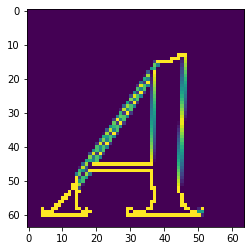

In [28]:
plt.imshow(np.array(data['rendered']).reshape(64, 64))

Подготовим даталоадеры.

In [29]:
data_train.loc[0, :]

uni                                                         97
width                                                      649
vwidth                                                    1000
sfd          SplineSet\n637 0 m 1,0,-1\n 595 0 l 1,1,-1\n 5...
id                                                           1
binary_fp                               12127215344058962203\n
Name: 0, dtype: object

In [161]:
import random

class GlyphDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.map_class = {}
        self.cached = self.__getitem__(0)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        while True:
            idx=0
            try:
                example = np.array(svg_utils._create_example(svg_utils._convert_to_path(self.df.loc[idx, :]))['rendered']
                                  , dtype=np.float32)

                if not (self.df.loc[idx, "uni"] in self.map_class):
                    len_ind = len(self.map_class)
                    self.map_class[self.df.loc[idx, "uni"]] = len_ind


                std_dev = np.std(example)
                mean = np.mean(example)
                example /= 255
#                 example = (example - mean) / std_dev 
                
                return torch.FloatTensor(example.reshape(1, 64, 64)), self.map_class[self.df.loc[idx, "uni"]]
            except Exception as e:
                idx = random.randint(0, len(self) - 1)
                continue

In [173]:
glyph_train = GlyphDataset(data_train[:50000])
glyph_test = GlyphDataset(data_test)

In [174]:
train_loader = DataLoader(glyph_train, batch_size=128, num_workers=2, pin_memory=True)
for X_batch, Y_batch in train_loader:
    print(X_batch)
    print(Y_batch)
    break

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

## Model declaration

In [175]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
config = ImageVAEConfig('cuda')

In [177]:
device = torch.device('cuda')

In [178]:
model = VAEModel(config).to(device)

In [179]:
from torchsummary import summary

summary(model, [(1, 64, 64), (1, 1, 1)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             832
    InstanceNorm2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
 VisualEncoderCell-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 32, 32, 32]          25,632
    InstanceNorm2d-6           [-1, 32, 32, 32]               0
              ReLU-7           [-1, 32, 32, 32]               0
 VisualEncoderCell-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          51,264
   InstanceNorm2d-10           [-1, 64, 32, 32]               0
             ReLU-11           [-1, 64, 32, 32]               0
VisualEncoderCell-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 16, 16]         102,464
   InstanceNorm2d-14           [-1, 64,

## Training

In [180]:
opt = torch.optim.Adam(model.parameters(), lr=3e-6, eps=1e-8)
# opt = torch.optim.SGD(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=4, min_lr=0.000001)

In [181]:
hello = []

In [182]:
hello

[]

In [183]:
import time
from tqdm.notebook import tqdm


def train_model(model, opt, scheduler, train_loss, 
                val_accuracy, num_epochs, print_every=5):
    cur_max_acc = None
    for epoch in tqdm(range(num_epochs)):
        #print(f'Start epoch {epoch}')
        start_time = time.time()
        model.train()
        epoch_loss = 0
        i = 0
        for X_batch, Y_batch in tqdm(train_loader):
            logits, losses = model(X_batch.to(device), Y_batch.to(device))
            loss = losses['training']
            #train_loss.append(loss.item())
#             print(loss.item())
            loss.backward()
            hello.append(model.decoder.block1.conv2d.weight.grad.detach().cpu())
            opt.step()
            opt.zero_grad()
            epoch_loss += loss.item()
            if i % print_every == 0:
                plt.imshow(X_batch[0][0])
                plt.show()
                plt.imshow(logits.detach().cpu().numpy()[0][0])
                plt.show()
                #plt.plot(train_loss)
                print(f'Epoch {epoch}, Batch {i}, loss {loss.item()}')
            i += 1
        
        train_loss.append(epoch_loss)
        plt.plot(train_loss)
        plt.show()
        #cur_val_acc, cur_val_loss = get_accuracy(model, val_batch_gen)
        #epoch_loss /= len(train_batch_gen)
        #scheduler.step(cur_val_loss)
        
        #train_loss.append(epoch_loss)
        #val_accuracy.append(cur_val_acc)
        #val_loss.append(cur_val_loss)
        
        #print("Epoch {} of {} took {:.3f}s".format(
        #    epoch + 1, num_epochs, time.time() - start_time))
        #print('  lr =', scheduler._last_lr[0])
        #print("  training loss (in-iteration): \t{:.6f}".format(epoch_loss))
        #print("  validate loss (in-iteration): \t{:.6f}".format(cur_val_loss))
        #print("  validation accuracy: \t\t\t{:.2f} %".format(cur_val_acc * 100))
        #if cur_max_acc is None or cur_val_acc > cur_max_acc:
        #    cur_max_acc = cur_val_acc
        #    torch.save(model.state_dict(), 'models/residual.best4')

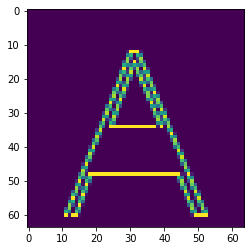

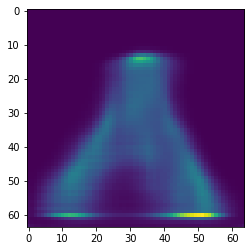

Epoch 0, Batch 0, loss 655.0685424804688


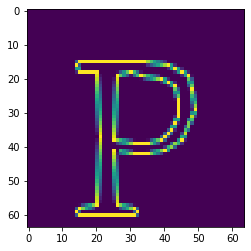

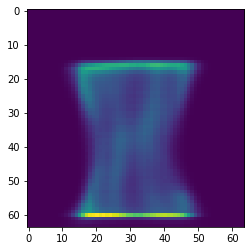

Epoch 0, Batch 100, loss 605.00390625


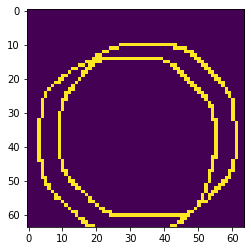

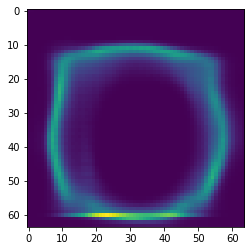

Epoch 0, Batch 200, loss 756.1041870117188


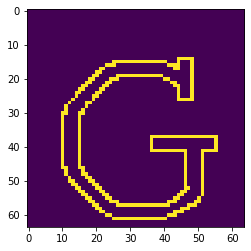

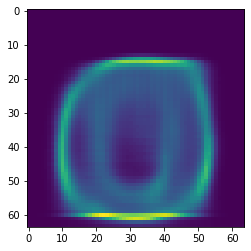

Epoch 0, Batch 300, loss 574.4769287109375


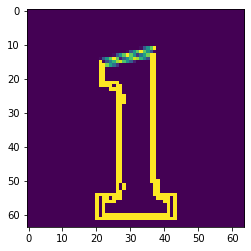

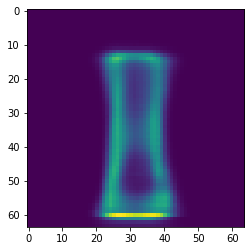

Epoch 0, Batch 400, loss 632.2730712890625


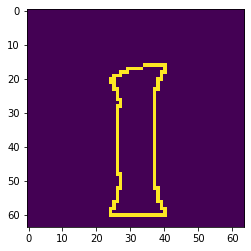

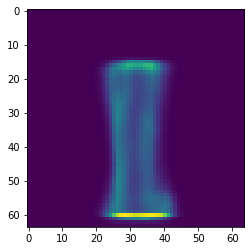

Epoch 0, Batch 500, loss 728.9631958007812


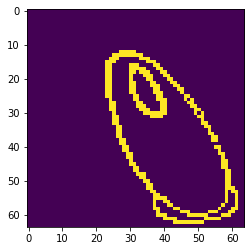

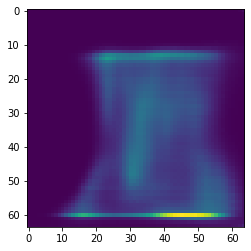

Epoch 0, Batch 600, loss 655.2940063476562


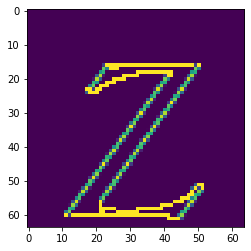

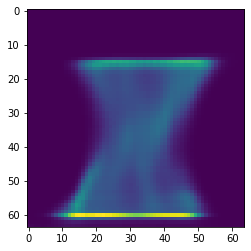

Epoch 0, Batch 700, loss 719.8250732421875


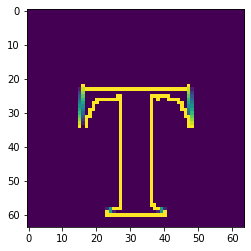

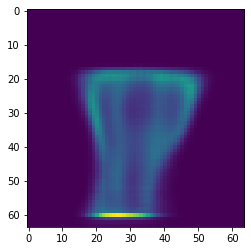

Epoch 0, Batch 800, loss 575.47314453125


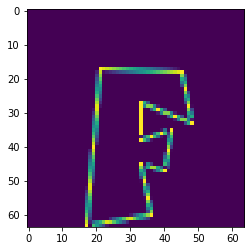

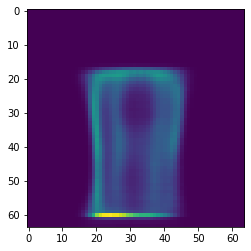

Epoch 0, Batch 900, loss 524.7512817382812


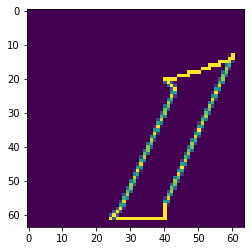

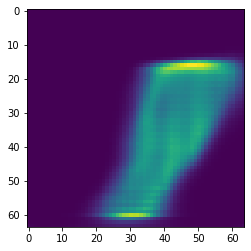

Epoch 0, Batch 1000, loss 696.2899169921875


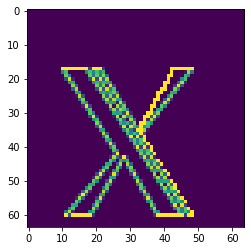

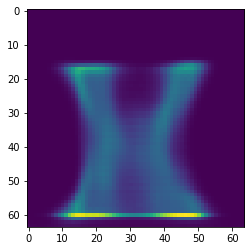

Epoch 0, Batch 1100, loss 643.0817260742188


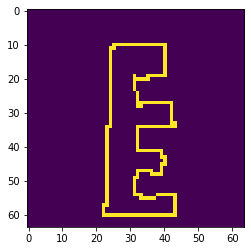

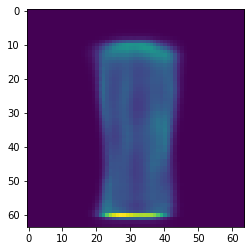

Epoch 0, Batch 1200, loss 522.6437377929688


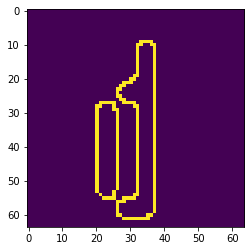

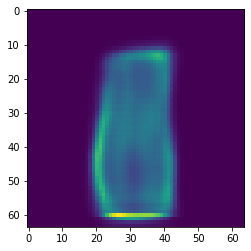

Epoch 0, Batch 1300, loss 610.895751953125


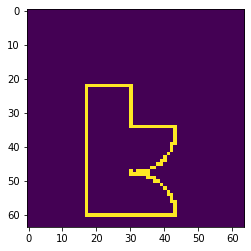

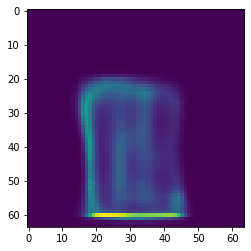

Epoch 0, Batch 1400, loss 498.61773681640625


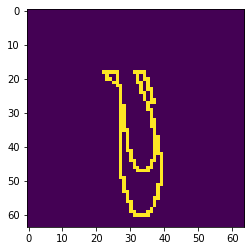

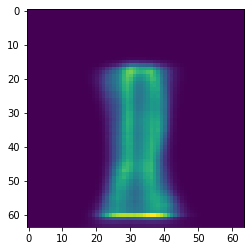

Epoch 0, Batch 1500, loss 572.21533203125


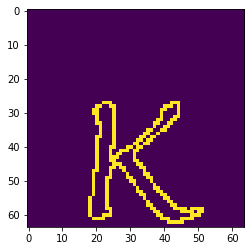

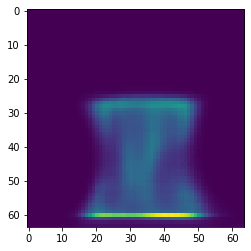

Epoch 0, Batch 1600, loss 595.1981201171875


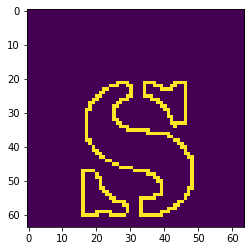

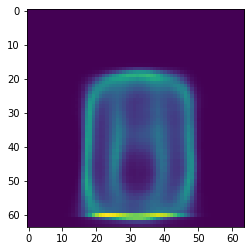

Epoch 0, Batch 1700, loss 777.869873046875


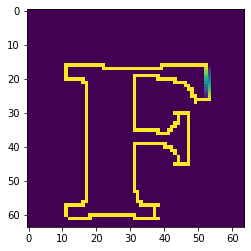

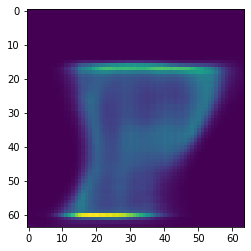

Epoch 0, Batch 1800, loss 591.4263916015625


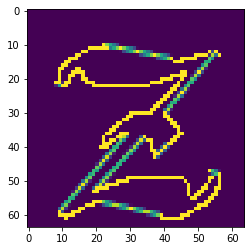

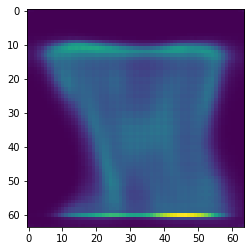

Epoch 0, Batch 1900, loss 551.8757934570312


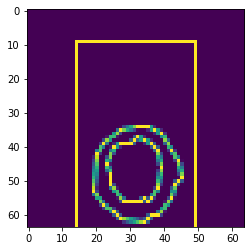

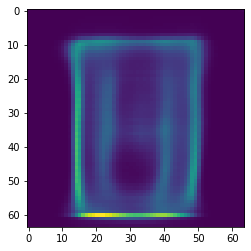

Epoch 0, Batch 2000, loss 667.2188720703125


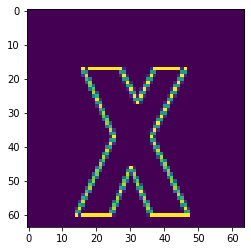

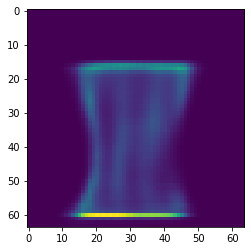

Epoch 0, Batch 2100, loss 540.37158203125


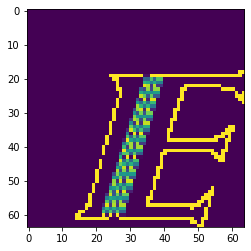

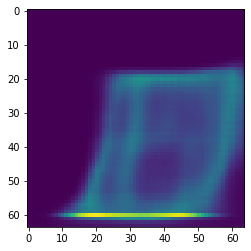

Epoch 0, Batch 2200, loss 546.3973388671875


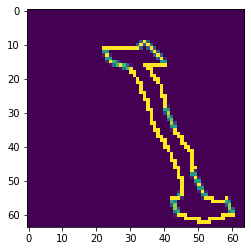

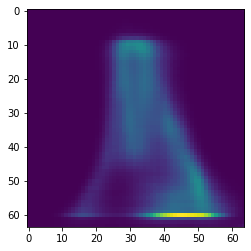

Epoch 0, Batch 2300, loss 566.8543701171875


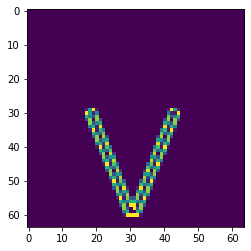

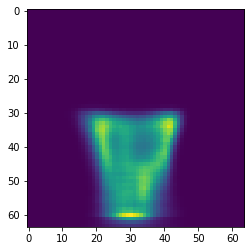

Epoch 0, Batch 2400, loss 544.308837890625


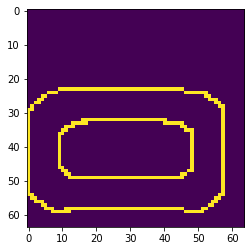

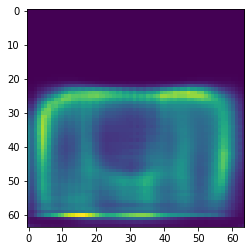

Epoch 0, Batch 2500, loss 589.697265625


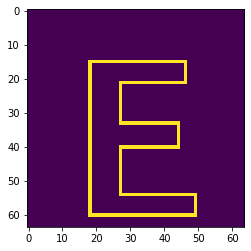

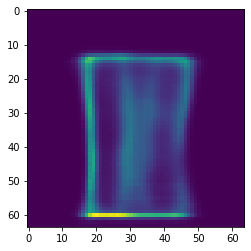

Epoch 0, Batch 2600, loss 632.2862548828125


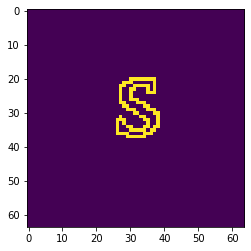

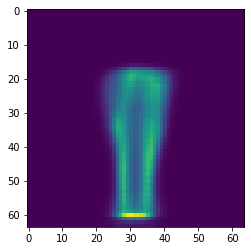

Epoch 0, Batch 2700, loss 579.25537109375


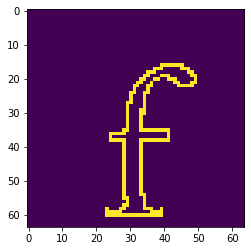

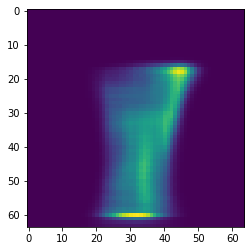

Epoch 0, Batch 2800, loss 487.2604675292969


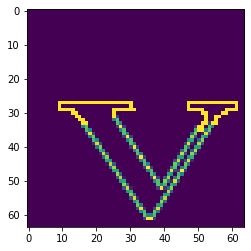

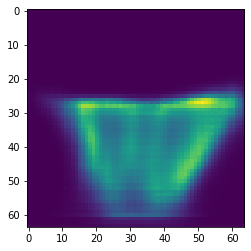

Epoch 0, Batch 2900, loss 658.258056640625


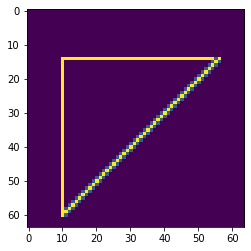

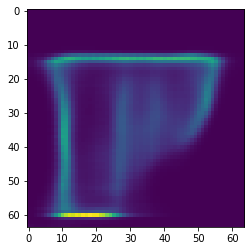

Epoch 0, Batch 3000, loss 545.8196411132812


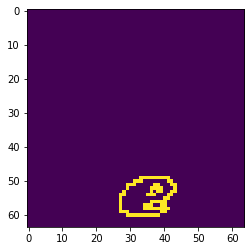

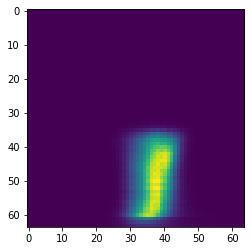

Epoch 0, Batch 3100, loss 597.06396484375


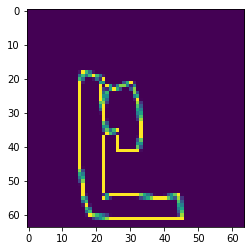

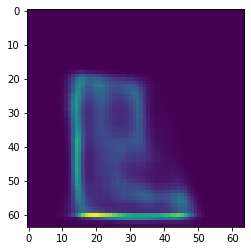

Epoch 0, Batch 3200, loss 537.7809448242188


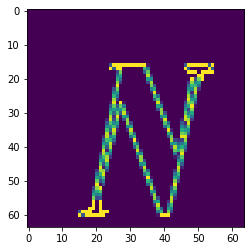

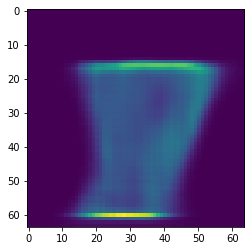

Epoch 0, Batch 3300, loss 507.6264953613281


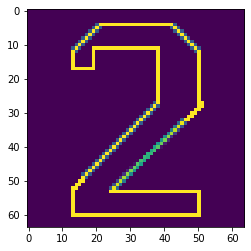

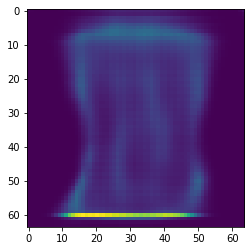

Epoch 0, Batch 3400, loss 625.4669799804688


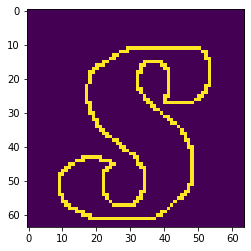

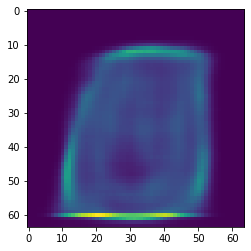

Epoch 0, Batch 3500, loss 735.428955078125


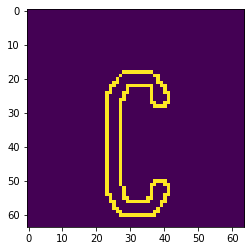

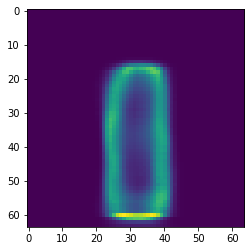

Epoch 0, Batch 3600, loss 530.8313598632812


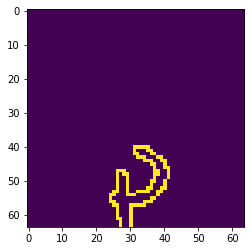

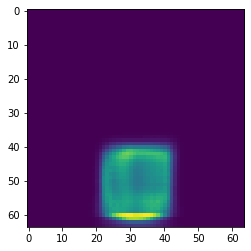

Epoch 0, Batch 3700, loss 511.1045837402344


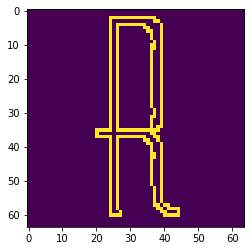

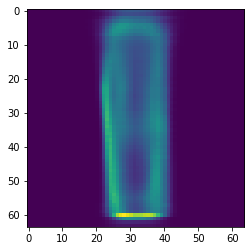

Epoch 0, Batch 3800, loss 660.74267578125


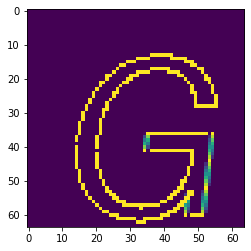

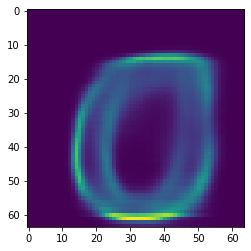

Epoch 0, Batch 3900, loss 596.110595703125


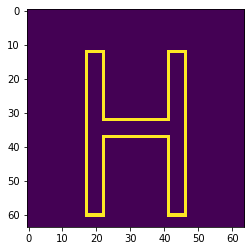

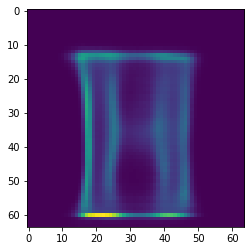

Epoch 0, Batch 4000, loss 602.6346435546875


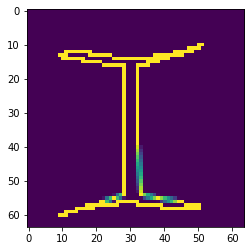

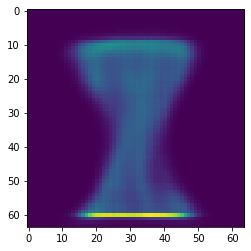

Epoch 0, Batch 4100, loss 629.5252685546875


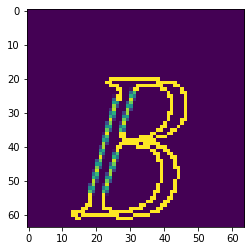

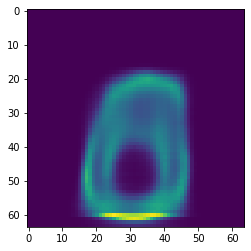

Epoch 0, Batch 4200, loss 548.9818725585938


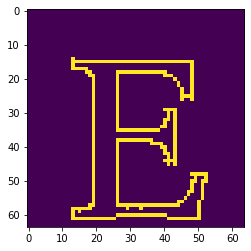

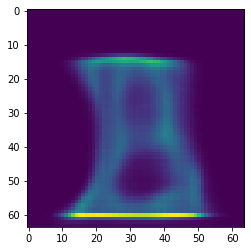

Epoch 0, Batch 4300, loss 597.7730712890625


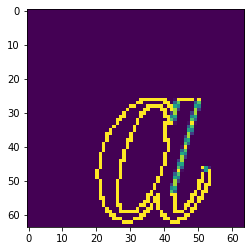

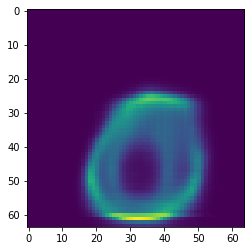

Epoch 0, Batch 4400, loss 572.687744140625


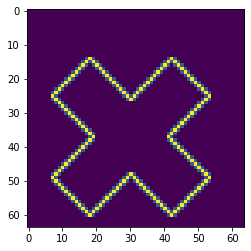

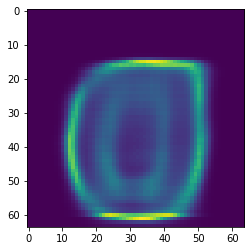

Epoch 0, Batch 4500, loss 609.6123046875


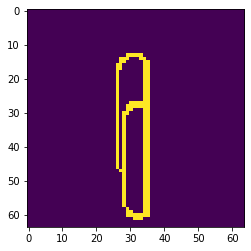

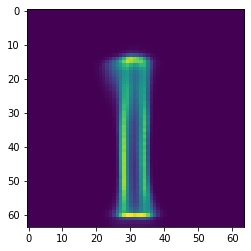

Epoch 0, Batch 4600, loss 649.44775390625


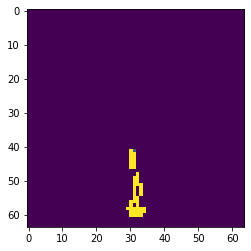

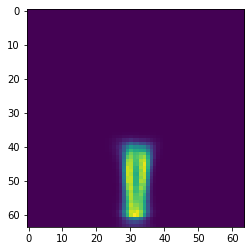

Epoch 0, Batch 4700, loss 512.43212890625


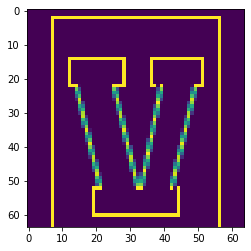

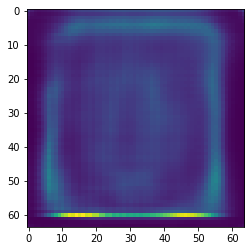

Epoch 0, Batch 4800, loss 802.1458129882812


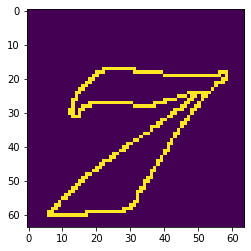

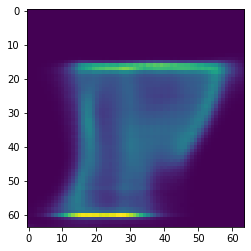

Epoch 0, Batch 4900, loss 644.7379760742188


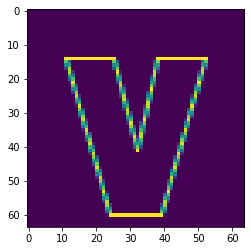

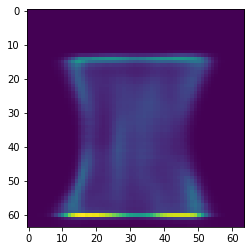

Epoch 0, Batch 5000, loss 630.4327392578125


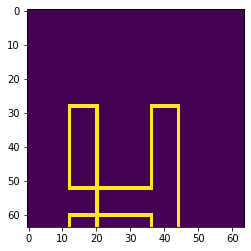

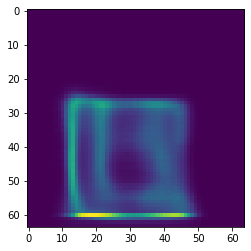

Epoch 0, Batch 5100, loss 595.5795288085938


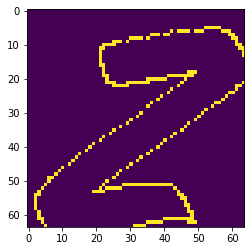

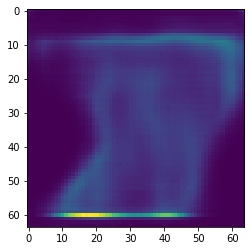

Epoch 0, Batch 5200, loss 520.9443359375


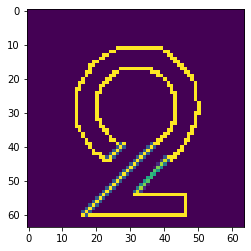

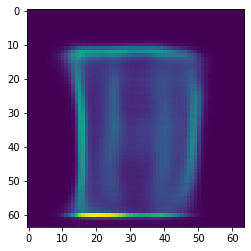

Epoch 0, Batch 5300, loss 578.0897216796875


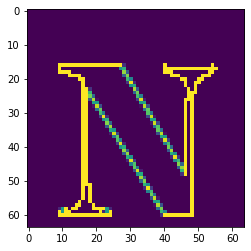

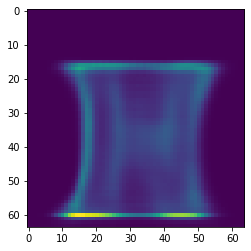

Epoch 0, Batch 5400, loss 566.264892578125


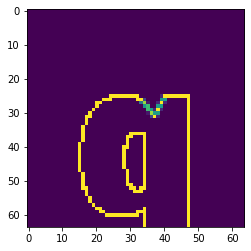

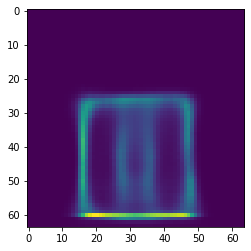

Epoch 0, Batch 5500, loss 542.2118530273438


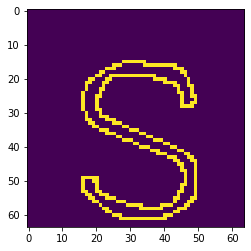

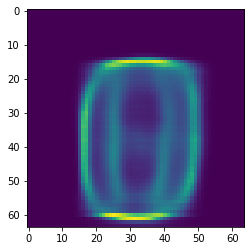

Epoch 0, Batch 5600, loss 604.3327026367188


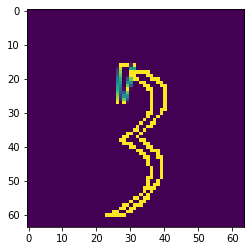

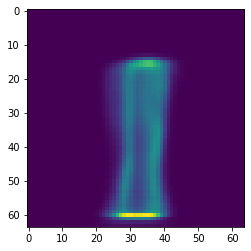

Epoch 0, Batch 5700, loss 541.7454833984375


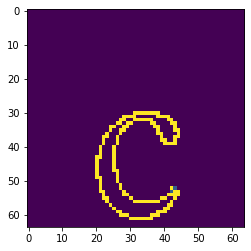

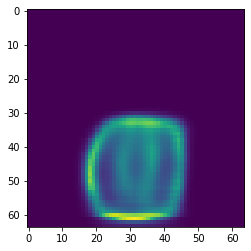

Epoch 0, Batch 5800, loss 575.7678833007812


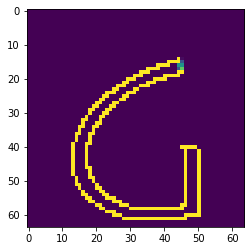

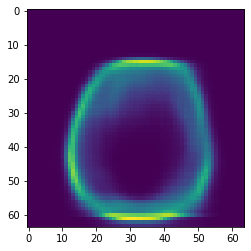

Epoch 0, Batch 5900, loss 634.08984375


KeyboardInterrupt: 

In [148]:
train_model(model, opt, scheduler, train_loss, val_accuracy, 10, 100)

In [ ]:
torch.save(model.state_dict(), 'residual.best4')

## Sampling

In [ ]:
model.eval()

In [244]:
img = model.decoder(torch.randn(32).to(device), torch.Tensor([1]))

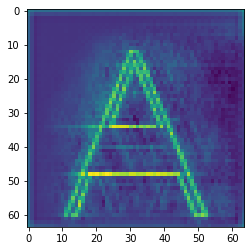

In [245]:
plt.imshow(np.array(img[0][0].cpu().detach()))